## Convolutional & Conditional VAEs

In this problem you will implement: 
1. a **convolutional** variational autoencoder
2. a (convolutional) **conditional** variational autoencoder,

trained on the MNIST dataset. 
The convolutional parameterization will help you achieve better marginal log likelihood. Using the conditional VAE, you'll be able to generate novel images of a specified class.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
%pylab inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.distributions import MultivariateNormal
import torch.nn.functional as F

Populating the interactive namespace from numpy and matplotlib


In [ ]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True, 
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)




---
# 1. Convolutional variational autoencoder (20 points)


Your task is to implement a VAE for MNIST, using a **convolutional network** in the encoder, and a **convolutional network** in the decoder.

- **Overall Goal:** achieve better estimated marginal likelihood than in the lab
  - Keep `z=20` as in the lab 


**Encoder**: you are free to design the convolutional network how you want. 
  - We used three `Conv2d + ReLU` layers, with an output size of `B x 64 x 7 x 7`.
  - Hint: Flatten the output of your convolutional network before mapping it to the encoder outputs, e.g. $\mu = \texttt{linear(flatten(conv(x)))}$


**Decoder**: you are free to design the convolutional network how you want. 
  - We used three `ConvTranspose2d + ReLU` layers, with an input size of `B x 64 x 7 x 7`.
  - Hint: Map the $\mathbf{z}$ input to the convolutional input size.
    - $\hat{x}=\texttt{deconv(reshape(linear(z)))}$

In [ ]:
class Encoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    c = 32
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: batch x 32 x 14 x 14
    self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: batch x 64 x 7 x 7
    self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=zdim)
    self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=zdim)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    # batch x (64*7*7)
    mu = self.fc_mu(x.view(x.size(0), -1))
    logvar = self.fc_logvar(x.view(x.size(0), -1))
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    c = 32
    self.fc = nn.Linear(in_features=zdim, out_features=c*2*7*7)
    self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
    self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
  
  def forward(self, x):
    x = self.fc(x)
    x = F.relu(self.conv2(x.view(x.size(0), -1, 7, 7))) # batch x 64 x 7 x 7
    x = torch.sigmoid(self.conv1(x))
    return x


class VAE(nn.Module):
  def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder(20)
        self.decoder = Decoder(20)
    
  def forward(self, x):
      mu, logvar = self.encoder(x)
      latent = self.reparameterize(mu, logvar)
      x_recon = self.decoder(latent)
      return x_recon, mu, logvar
  
  def reparameterize(self, mu, logvar):
      if self.training:
          # the reparameterization trick
          std = logvar.mul(0.5).exp_()
          eps = torch.empty_like(std).normal_()
          return eps.mul(std).add_(mu)
      else:
          return mu

**Loss**: does anything change from the lab?\
Need to reshape the images

In [ ]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
  BCE = nn.functional.binary_cross_entropy(
      xhat.view(x.size(0), -1), x.view(x.size(0), -1), reduction='none'
  ).sum(1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

  loss = BCE + kl_weight*KLD
  return loss, BCE.item(), KLD.item()

**Train on MNIST**: does anything change from the lab?\
No

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.

In [ ]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this
batch_size = 256
device = torch.device("cuda:0") 
model = VAE().to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

In [ ]:
from tqdm.notebook import tqdm

def train(epoch):
  model.train()
  train_loss, bce, kld = 0.0, 0.0, 0.0
  for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
      x = x.to(device)

      optimizer.zero_grad()
      xhat, mu, logvar = model(x)
      loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
      loss.backward()
      optimizer.step()

      train_loss += float(loss.item())
      bce += float(bce_)
      kld += float(kld_)

  print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
      epoch, 
      train_loss / len(train_loader.dataset),
      bce / len(train_loader.dataset),
      kld / len(train_loader.dataset)
  ))
  return train_loss / len(train_loader.dataset), bce / len(train_loader.dataset), kld / len(train_loader.dataset)


def validate(epoch):
    cache = dict(mus=[], logvars=[], ys=[])
    mus, logvars, ys = [], [], []
    model.eval()
    test_loss, bce, kld = 0.0, 0.0, 0.0
    with torch.no_grad():
        for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            x = x.to(device)
            xhat, mu, logvar = model(x)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

            test_loss += float(loss.item())
            bce += float(bce_)
            kld += float(kld_)
            cache['mus'].append(mu.detach())
            cache['logvars'].append(logvar.detach())
            cache['ys'].append(y.detach())

    test_loss /= len(test_loader.dataset)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce / len(test_loader.dataset),
        kld / len(test_loader.dataset)
    ))
    return cache, test_loss, bce / len(test_loader.dataset), kld / len(test_loader.dataset)

# train, validate ..
best_loss = 1e8
cache = dict(mus=[], logvars=[], ys=[], valid_loss=[])
train_cache = dict(loss=[], bce=[], kld=[])
valid_cache = dict(loss=[], bce=[], kld=[])
for epoch in range(1, 50):
  cache_, valid_loss, valid_bce, valid_kld = validate(epoch)
  valid_cache["loss"].append(valid_loss)
  valid_cache["bce"].append(valid_bce)
  valid_cache["kld"].append(valid_kld)
  train_loss, train_bce, train_kld = train(epoch)
  train_cache["loss"].append(train_loss)
  train_cache["bce"].append(train_bce)
  train_cache["kld"].append(train_kld)
  
  for k in cache_:
    cache[k].append(torch.cat(cache_[k]))
  cache['valid_loss'].append(valid_loss)

  if valid_loss < best_loss:
    torch.save({
        'state_dict': model.state_dict(),
        'valid_loss': cache['valid_loss']
    }, '/content/drive/My Drive/DS1008/HW4/model.pt')
    best_loss = valid_loss


====> Valid set loss: 2.3642 (bce 2.3640, kld 0.0002)



====> Epoch: 1 Average loss: 0.7277 (bce 0.6481, kld 0.0796)



====> Valid set loss: 0.4797 (bce 0.3793, kld 0.1005)



====> Epoch: 2 Average loss: 0.4780 (bce 0.3752, kld 0.1028)



====> Valid set loss: 0.4285 (bce 0.3208, kld 0.1077)



====> Epoch: 3 Average loss: 0.4508 (bce 0.3456, kld 0.1052)



====> Valid set loss: 0.4140 (bce 0.3055, kld 0.1085)



====> Epoch: 4 Average loss: 0.4375 (bce 0.3324, kld 0.1051)



====> Valid set loss: 0.4026 (bce 0.2941, kld 0.1086)



====> Epoch: 5 Average loss: 0.4294 (bce 0.3247, kld 0.1048)



====> Valid set loss: 0.3949 (bce 0.2894, kld 0.1055)



====> Epoch: 6 Average loss: 0.4237 (bce 0.3195, kld 0.1042)



====> Valid set loss: 0.3913 (bce 0.2851, kld 0.1062)



====> Epoch: 7 Average loss: 0.4196 (bce 0.3158, kld 0.1037)



====> Valid set loss: 0.3905 (bce 0.2830, kld 0.1075)



====> Epoch: 8 Average loss: 0.4163 (bce 0.3127, kld 0.1035)



====> Valid set loss: 0.3852 (bce 0.2795, kld 0.1056)



====> Epoch: 9 Average loss: 0.4139 (bce 0.3106, kld 0.1033)



====> Valid set loss: 0.3811 (bce 0.2784, kld 0.1027)



====> Epoch: 10 Average loss: 0.4118 (bce 0.3087, kld 0.1031)



====> Valid set loss: 0.3809 (bce 0.2773, kld 0.1036)



====> Epoch: 11 Average loss: 0.4101 (bce 0.3072, kld 0.1029)



====> Valid set loss: 0.3785 (bce 0.2745, kld 0.1040)



====> Epoch: 12 Average loss: 0.4084 (bce 0.3058, kld 0.1026)



====> Valid set loss: 0.3784 (bce 0.2747, kld 0.1038)



====> Epoch: 13 Average loss: 0.4072 (bce 0.3046, kld 0.1026)



====> Valid set loss: 0.3785 (bce 0.2730, kld 0.1055)



====> Epoch: 14 Average loss: 0.4058 (bce 0.3034, kld 0.1023)



====> Valid set loss: 0.3757 (bce 0.2720, kld 0.1036)



====> Epoch: 15 Average loss: 0.4046 (bce 0.3024, kld 0.1022)



====> Valid set loss: 0.3747 (bce 0.2708, kld 0.1039)



====> Epoch: 16 Average loss: 0.4037 (bce 0.3017, kld 0.1020)



====> Valid set loss: 0.3748 (bce 0.2711, kld 0.1037)



====> Epoch: 17 Average loss: 0.4028 (bce 0.3007, kld 0.1020)



====> Valid set loss: 0.3743 (bce 0.2698, kld 0.1045)



====> Epoch: 18 Average loss: 0.4020 (bce 0.3001, kld 0.1019)



====> Valid set loss: 0.3777 (bce 0.2698, kld 0.1080)



====> Epoch: 19 Average loss: 0.4010 (bce 0.2993, kld 0.1017)



====> Valid set loss: 0.3716 (bce 0.2692, kld 0.1024)



====> Epoch: 20 Average loss: 0.4004 (bce 0.2987, kld 0.1018)



====> Valid set loss: 0.3718 (bce 0.2692, kld 0.1026)



====> Epoch: 21 Average loss: 0.3995 (bce 0.2980, kld 0.1015)



====> Valid set loss: 0.3712 (bce 0.2688, kld 0.1024)



====> Epoch: 22 Average loss: 0.3991 (bce 0.2977, kld 0.1014)



====> Valid set loss: 0.3721 (bce 0.2671, kld 0.1050)



====> Epoch: 23 Average loss: 0.3982 (bce 0.2968, kld 0.1014)



====> Valid set loss: 0.3685 (bce 0.2694, kld 0.0991)



====> Epoch: 24 Average loss: 0.3977 (bce 0.2966, kld 0.1011)



====> Valid set loss: 0.3703 (bce 0.2663, kld 0.1040)



====> Epoch: 25 Average loss: 0.3972 (bce 0.2961, kld 0.1011)



====> Valid set loss: 0.3688 (bce 0.2674, kld 0.1014)



====> Epoch: 26 Average loss: 0.3965 (bce 0.2956, kld 0.1009)



====> Valid set loss: 0.3695 (bce 0.2651, kld 0.1043)



====> Epoch: 27 Average loss: 0.3961 (bce 0.2952, kld 0.1008)



====> Valid set loss: 0.3673 (bce 0.2656, kld 0.1017)



====> Epoch: 28 Average loss: 0.3956 (bce 0.2949, kld 0.1007)



====> Valid set loss: 0.3677 (bce 0.2654, kld 0.1023)



====> Epoch: 29 Average loss: 0.3951 (bce 0.2945, kld 0.1006)



====> Valid set loss: 0.3672 (bce 0.2658, kld 0.1015)



====> Epoch: 30 Average loss: 0.3946 (bce 0.2940, kld 0.1006)



====> Valid set loss: 0.3658 (bce 0.2651, kld 0.1007)



====> Epoch: 31 Average loss: 0.3942 (bce 0.2938, kld 0.1004)



====> Valid set loss: 0.3665 (bce 0.2656, kld 0.1009)



====> Epoch: 32 Average loss: 0.3938 (bce 0.2935, kld 0.1003)



====> Valid set loss: 0.3683 (bce 0.2644, kld 0.1039)



====> Epoch: 33 Average loss: 0.3935 (bce 0.2932, kld 0.1003)



====> Valid set loss: 0.3657 (bce 0.2649, kld 0.1008)



====> Epoch: 34 Average loss: 0.3929 (bce 0.2927, kld 0.1002)



====> Valid set loss: 0.3653 (bce 0.2645, kld 0.1009)



====> Epoch: 35 Average loss: 0.3927 (bce 0.2926, kld 0.1001)



====> Valid set loss: 0.3648 (bce 0.2641, kld 0.1007)



====> Epoch: 36 Average loss: 0.3923 (bce 0.2922, kld 0.1001)



====> Valid set loss: 0.3631 (bce 0.2638, kld 0.0994)



====> Epoch: 37 Average loss: 0.3920 (bce 0.2922, kld 0.0998)



====> Valid set loss: 0.3661 (bce 0.2647, kld 0.1014)



====> Epoch: 38 Average loss: 0.3917 (bce 0.2918, kld 0.0999)



====> Valid set loss: 0.3680 (bce 0.2639, kld 0.1041)



====> Epoch: 39 Average loss: 0.3913 (bce 0.2915, kld 0.0998)



====> Valid set loss: 0.3641 (bce 0.2638, kld 0.1003)



====> Epoch: 40 Average loss: 0.3910 (bce 0.2914, kld 0.0996)



====> Valid set loss: 0.3647 (bce 0.2637, kld 0.1010)



====> Epoch: 41 Average loss: 0.3908 (bce 0.2912, kld 0.0996)



====> Valid set loss: 0.3636 (bce 0.2638, kld 0.0998)



====> Epoch: 42 Average loss: 0.3905 (bce 0.2910, kld 0.0995)



====> Valid set loss: 0.3641 (bce 0.2643, kld 0.0998)



====> Epoch: 43 Average loss: 0.3903 (bce 0.2906, kld 0.0997)



====> Valid set loss: 0.3627 (bce 0.2631, kld 0.0996)



====> Epoch: 44 Average loss: 0.3900 (bce 0.2905, kld 0.0995)



====> Valid set loss: 0.3625 (bce 0.2624, kld 0.1001)



====> Epoch: 45 Average loss: 0.3900 (bce 0.2905, kld 0.0995)



====> Valid set loss: 0.3657 (bce 0.2622, kld 0.1035)



====> Epoch: 46 Average loss: 0.3895 (bce 0.2901, kld 0.0994)



====> Valid set loss: 0.3642 (bce 0.2630, kld 0.1012)



====> Epoch: 47 Average loss: 0.3893 (bce 0.2900, kld 0.0993)



====> Valid set loss: 0.3639 (bce 0.2631, kld 0.1009)



====> Epoch: 48 Average loss: 0.3892 (bce 0.2899, kld 0.0993)



====> Valid set loss: 0.3635 (bce 0.2615, kld 0.1019)



====> Epoch: 49 Average loss: 0.3889 (bce 0.2897, kld 0.0992)


Text(0.5, 1.0, 'validation')

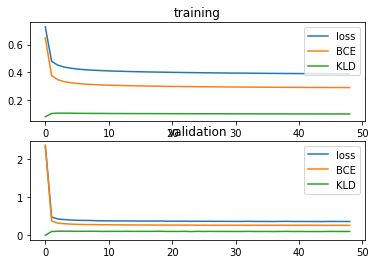

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(2, 1)
plt.subplot(2, 1, 1)
plt.plot(train_cache["loss"], label="loss")
plt.plot(train_cache["bce"], label="BCE")
plt.plot(train_cache["kld"], label="KLD")
plt.legend()
plt.title("training")
plt.subplot(2, 1, 2)
plt.plot(valid_cache["loss"], label="loss")
plt.plot(valid_cache["bce"], label="BCE")
plt.plot(valid_cache["kld"], label="KLD")
plt.legend()
plt.title("validation")

### Evaluation
- **We provide the code below for sampling, interpolation, and marginal likelihood estimation**
- Sampling and interpolation: achieve similar to the lab (this is subjective, so the purpose is to check if something is *way off*)
- Marginal likelihood: achieve lower than the lab



*Please ensure that `model` contains the model state that you will use for evaluation before running these.*

In [ ]:
model = VAE().to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/DS1008/HW4/model.pt')["state_dict"])

<All keys matched successfully>

#### Sampling

*no code modification needed*

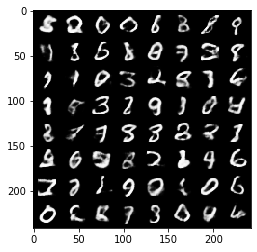

In [ ]:
from torchvision.utils import make_grid

N = 64
model.eval()

# Sample z~p(z)
z = torch.randn((N, zdim)).to(device)

# Decode
sample = model.decoder(z)

# Visualize
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

imgs = sample
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Interpolation

*no code modification needed*

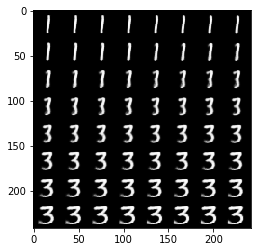

In [ ]:
model.eval()

x, y = next(train_loader.__iter__())
xhat, mu, logvar = model(x.cuda())
si, ei = np.random.choice(batch_size, size=2, replace=False)
start = mu[si]
end = mu[ei]

N = 64

zs = torch.zeros(N, zdim).to(device)
for i in range(N):
    zs[i] = i / (N) * start.data + (1 - i / (N) ) * end.data
xhat = model.decoder(zs)

imgs = xhat.unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Marginal likelihood

*no code modification needed*

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

eval_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

N_samples = 128

model.eval()
results = []
with torch.no_grad():
  for i, (x, y) in tqdm(enumerate(eval_loader), total=len(eval_loader)):
    x, y = next(eval_loader.__iter__())
    x = x.to(device).expand(N_samples, 1, 28, 28)

    # Obtain mu, logvar and sample z
    _, mu, logvar = model(x)
    z = mu + logvar.mul(0.5).exp()*torch.randn_like(mu)

    # Obtain xhat given the sampled z
    xhat = model.decoder(z)

    # Make a standard normal for p(z) and a normal for q(z|x)
    norm = MultivariateNormal(
        torch.zeros_like(mu[0]), 
        covariance_matrix=torch.diag(torch.ones_like(logvar[0]))
    )
    mvn = MultivariateNormal(
        mu[0], 
        covariance_matrix=torch.diag(logvar.exp()[0])
    )

    # Measure the (log) probabilities needed for the formula above
    log_pz = norm.log_prob(z)
    log_qzx = mvn.log_prob(z)
    x = x.view(xhat.size())
    log_pxz = -nn.functional.binary_cross_entropy(
        xhat, x, reduction='none'
    ).view(N_samples, -1).sum(1)

    # Compute the lowerbound (in log space)
    argsum = log_pxz + log_pz - log_qzx
    logpx = -np.log(N_samples) + torch.logsumexp(argsum, 0)
    results.append(logpx.item())

np.mean(results)

-95.09067152557373



---

# 2. Conditional variational autoencoder (20 points)

### A. Model

The conditional VAE involves:
- $q_{\phi}(\mathbf{z}|\mathbf{x},c)$: "encoder"
- $p_{\theta}(\mathbf{x}|\mathbf{z},c)$: "decoder"
- $p(\mathbf{z})$: prior

In our case, $c\in \{0,...,9\}$ is a discrete variable (class label).

**Your task:** Implement a `CVAE` that has an `encoder`, `decoder`, and `reparameterization`.

*Hints*: 
  1. Represent $c$ using a `nn.Embedding` layer, and concatenate it to the representation of $\mathbf{x}$.
    - e.g. $\mu = \texttt{linear([conv(x); emb(c)])}$
  2. Represent `decoder` inputs $\mathbf{z},c$ similarly, as $[\mathbf{z};\text{emb}(c)]$.
    - $\hat{x}=\texttt{deconv(linear([z; emb(c)]))}$

Otherwise, everything else is the same as VAE (plus passing $c$ as an argument in the right places). You can use the same convolutional layers as above.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    c = 32
    d = 32
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: batch x 32 x 14 x 14
    self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: batch x 64 x 7 x 7
    self.fc_mu = nn.Linear(in_features=c*2*7*7 + d, out_features=zdim)
    self.fc_logvar = nn.Linear(in_features=c*2*7*7 + d, out_features=zdim)
    self.emb = nn.Embedding(nclasses, d)

  def forward(self, x, c):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    c = self.emb(c)
    mu = self.fc_mu(torch.cat((x.view(x.size(0), -1), c), dim=1)) # batch x (features + emb)
    logvar = self.fc_logvar(torch.cat((x.view(x.size(0), -1), c), dim=1))
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    c = 32
    d = 32
    self.emb = nn.Embedding(nclasses, d)
    self.fc = nn.Linear(in_features=zdim + d, out_features=c*2*7*7)
    self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
    self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
  
  def forward(self, z, c):
    c = self.emb(c)
    x = self.fc(torch.cat((z, c), dim=1))
    x = F.relu(self.conv2(x.view(x.size(0), -1, 7, 7))) # batch x 64 x 7 x 7
    x = torch.sigmoid(self.conv1(x))
    return x


class CVAE(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    self.encoder = Encoder(zdim, nclasses)
    self.decoder = Decoder(zdim, nclasses)

  def reparameterize(self, mu, logvar):
    if self.training:
        # the reparameterization trick
        std = logvar.mul(0.5).exp_()
        eps = torch.empty_like(std).normal_()
        return eps.mul(std).add_(mu)
    else:
        return mu

  def forward(self, x, c):
    mu, logvar = self.encoder(x, c)
    latent = self.reparameterize(mu, logvar)
    x_recon = self.decoder(latent, c)
    return x_recon, mu, logvar

In [ ]:
batch = next(iter(train_loader))
encoder = Encoder(zdim, 10)
decoder = Decoder(zdim, 10)

In [ ]:
z = torch.rand((batch_size, zdim))
c = torch.randint(high=10, size=(batch_size,))

In [ ]:
decoder(z, c).shape

torch.Size([256, 1, 28, 28])

In [ ]:
x = batch[0]
mu, logvar = encoder(x, c)
print(mu.shape, logvar.shape)

torch.Size([256, 20]) torch.Size([256, 20])


In [ ]:
model = CVAE(zdim, 10)
x_recon, mu, logvar = model(x, c)
print(x_recon.shape, mu.shape, logvar.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256, 20]) torch.Size([256, 20])


**Loss:** same as VAE.

In [ ]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
  BCE = nn.functional.binary_cross_entropy(
      xhat.view(x.size(0), -1), x.view(x.size(0), -1), reduction='none'
  ).sum(1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

  loss = BCE + kl_weight*KLD
  return loss, BCE.item(), KLD.item()

### C. Training

Train your conditional VAE model using your loss function on MNIST.

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.


In [ ]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this
batch_size = 256
device = torch.device("cuda:0")
nclasses = 10 
model = CVAE(zdim, nclasses).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

In [ ]:
from tqdm.notebook import tqdm

def train(epoch):
  model.train()
  train_loss, bce, kld = 0.0, 0.0, 0.0
  for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      xhat, mu, logvar = model(x, y)
      loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
      loss.backward()
      optimizer.step()

      train_loss += float(loss.item())
      bce += float(bce_)
      kld += float(kld_)

  print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
      epoch, 
      train_loss / len(train_loader.dataset),
      bce / len(train_loader.dataset),
      kld / len(train_loader.dataset)
  ))
  return train_loss / len(train_loader.dataset), bce / len(train_loader.dataset), kld / len(train_loader.dataset)


def validate(epoch):
    cache = dict(mus=[], logvars=[], ys=[])
    mus, logvars, ys = [], [], []
    model.eval()
    test_loss, bce, kld = 0.0, 0.0, 0.0
    with torch.no_grad():
        for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            x = x.to(device)
            y = y.to(device)
            xhat, mu, logvar = model(x, y)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

            test_loss += float(loss.item())
            bce += float(bce_)
            kld += float(kld_)
            cache['mus'].append(mu.detach())
            cache['logvars'].append(logvar.detach())
            cache['ys'].append(y.detach())

    test_loss /= len(test_loader.dataset)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce / len(test_loader.dataset),
        kld / len(test_loader.dataset)
    ))
    return cache, test_loss, bce / len(test_loader.dataset), kld / len(test_loader.dataset)

# train, validate ..
best_loss = 1e8
cache = dict(mus=[], logvars=[], ys=[], valid_loss=[])
train_cache = dict(loss=[], bce=[], kld=[])
valid_cache = dict(loss=[], bce=[], kld=[])
for epoch in range(1, 50):
  cache_, valid_loss, valid_bce, valid_kld = validate(epoch)
  valid_cache["loss"].append(valid_loss)
  valid_cache["bce"].append(valid_bce)
  valid_cache["kld"].append(valid_kld)
  train_loss, train_bce, train_kld = train(epoch)
  train_cache["loss"].append(train_loss)
  train_cache["bce"].append(train_bce)
  train_cache["kld"].append(train_kld)
  
  for k in cache_:
    cache[k].append(torch.cat(cache_[k]))
  cache['valid_loss'].append(valid_loss)

  if valid_loss < best_loss:
    torch.save({
        'state_dict': model.state_dict(),
        'valid_loss': cache['valid_loss']
    }, '/content/drive/My Drive/DS1008/HW4/model_conditional.pt')
    best_loss = valid_loss


====> Valid set loss: 2.2360 (bce 2.2356, kld 0.0004)



====> Epoch: 1 Average loss: 0.6603 (bce 0.6030, kld 0.0573)



====> Valid set loss: 0.4374 (bce 0.3606, kld 0.0767)



====> Epoch: 2 Average loss: 0.4393 (bce 0.3561, kld 0.0832)



====> Valid set loss: 0.3930 (bce 0.3065, kld 0.0865)



====> Epoch: 3 Average loss: 0.4165 (bce 0.3301, kld 0.0863)



====> Valid set loss: 0.3833 (bce 0.2932, kld 0.0901)



====> Epoch: 4 Average loss: 0.4068 (bce 0.3198, kld 0.0871)



====> Valid set loss: 0.3741 (bce 0.2850, kld 0.0891)



====> Epoch: 5 Average loss: 0.4010 (bce 0.3136, kld 0.0874)



====> Valid set loss: 0.3689 (bce 0.2800, kld 0.0889)



====> Epoch: 6 Average loss: 0.3973 (bce 0.3097, kld 0.0876)



====> Valid set loss: 0.3663 (bce 0.2792, kld 0.0871)



====> Epoch: 7 Average loss: 0.3943 (bce 0.3068, kld 0.0875)



====> Valid set loss: 0.3641 (bce 0.2761, kld 0.0881)



====> Epoch: 8 Average loss: 0.3918 (bce 0.3042, kld 0.0875)



====> Valid set loss: 0.3619 (bce 0.2725, kld 0.0894)



====> Epoch: 9 Average loss: 0.3898 (bce 0.3025, kld 0.0872)



====> Valid set loss: 0.3611 (bce 0.2713, kld 0.0898)



====> Epoch: 10 Average loss: 0.3880 (bce 0.3008, kld 0.0871)



====> Valid set loss: 0.3594 (bce 0.2713, kld 0.0880)



====> Epoch: 11 Average loss: 0.3865 (bce 0.2997, kld 0.0869)



====> Valid set loss: 0.3589 (bce 0.2697, kld 0.0892)



====> Epoch: 12 Average loss: 0.3849 (bce 0.2983, kld 0.0866)



====> Valid set loss: 0.3576 (bce 0.2689, kld 0.0888)



====> Epoch: 13 Average loss: 0.3837 (bce 0.2971, kld 0.0865)



====> Valid set loss: 0.3563 (bce 0.2688, kld 0.0875)



====> Epoch: 14 Average loss: 0.3827 (bce 0.2965, kld 0.0862)



====> Valid set loss: 0.3535 (bce 0.2678, kld 0.0857)



====> Epoch: 15 Average loss: 0.3814 (bce 0.2953, kld 0.0861)



====> Valid set loss: 0.3542 (bce 0.2691, kld 0.0851)



====> Epoch: 16 Average loss: 0.3803 (bce 0.2946, kld 0.0857)



====> Valid set loss: 0.3524 (bce 0.2662, kld 0.0861)



====> Epoch: 17 Average loss: 0.3796 (bce 0.2938, kld 0.0857)



====> Valid set loss: 0.3515 (bce 0.2656, kld 0.0859)



====> Epoch: 18 Average loss: 0.3785 (bce 0.2930, kld 0.0855)



====> Valid set loss: 0.3529 (bce 0.2655, kld 0.0874)



====> Epoch: 19 Average loss: 0.3779 (bce 0.2927, kld 0.0852)



====> Valid set loss: 0.3503 (bce 0.2668, kld 0.0835)



====> Epoch: 20 Average loss: 0.3770 (bce 0.2920, kld 0.0850)



====> Valid set loss: 0.3506 (bce 0.2655, kld 0.0850)



====> Epoch: 21 Average loss: 0.3762 (bce 0.2913, kld 0.0849)



====> Valid set loss: 0.3517 (bce 0.2645, kld 0.0872)



====> Epoch: 22 Average loss: 0.3756 (bce 0.2910, kld 0.0846)



====> Valid set loss: 0.3492 (bce 0.2634, kld 0.0858)



====> Epoch: 23 Average loss: 0.3750 (bce 0.2905, kld 0.0846)



====> Valid set loss: 0.3497 (bce 0.2656, kld 0.0841)



====> Epoch: 24 Average loss: 0.3742 (bce 0.2899, kld 0.0843)



====> Valid set loss: 0.3489 (bce 0.2634, kld 0.0855)



====> Epoch: 25 Average loss: 0.3739 (bce 0.2896, kld 0.0843)



====> Valid set loss: 0.3489 (bce 0.2629, kld 0.0860)



====> Epoch: 26 Average loss: 0.3734 (bce 0.2892, kld 0.0842)



====> Valid set loss: 0.3523 (bce 0.2646, kld 0.0877)



====> Epoch: 27 Average loss: 0.3730 (bce 0.2889, kld 0.0841)



====> Valid set loss: 0.3497 (bce 0.2629, kld 0.0868)



====> Epoch: 28 Average loss: 0.3724 (bce 0.2884, kld 0.0840)



====> Valid set loss: 0.3474 (bce 0.2639, kld 0.0835)



====> Epoch: 29 Average loss: 0.3718 (bce 0.2881, kld 0.0837)



====> Valid set loss: 0.3478 (bce 0.2629, kld 0.0849)



====> Epoch: 30 Average loss: 0.3716 (bce 0.2879, kld 0.0838)



====> Valid set loss: 0.3464 (bce 0.2625, kld 0.0839)



====> Epoch: 31 Average loss: 0.3712 (bce 0.2877, kld 0.0836)



====> Valid set loss: 0.3486 (bce 0.2624, kld 0.0862)



====> Epoch: 32 Average loss: 0.3708 (bce 0.2873, kld 0.0835)



====> Valid set loss: 0.3464 (bce 0.2629, kld 0.0835)



====> Epoch: 33 Average loss: 0.3705 (bce 0.2871, kld 0.0834)



====> Valid set loss: 0.3473 (bce 0.2623, kld 0.0850)



====> Epoch: 34 Average loss: 0.3702 (bce 0.2869, kld 0.0833)



====> Valid set loss: 0.3463 (bce 0.2620, kld 0.0843)



====> Epoch: 35 Average loss: 0.3699 (bce 0.2866, kld 0.0833)



====> Valid set loss: 0.3462 (bce 0.2631, kld 0.0831)



====> Epoch: 36 Average loss: 0.3696 (bce 0.2864, kld 0.0832)



====> Valid set loss: 0.3458 (bce 0.2610, kld 0.0848)



====> Epoch: 37 Average loss: 0.3693 (bce 0.2861, kld 0.0832)



====> Valid set loss: 0.3456 (bce 0.2627, kld 0.0829)



====> Epoch: 38 Average loss: 0.3693 (bce 0.2861, kld 0.0832)



====> Valid set loss: 0.3465 (bce 0.2619, kld 0.0846)



====> Epoch: 39 Average loss: 0.3688 (bce 0.2857, kld 0.0830)



====> Valid set loss: 0.3439 (bce 0.2616, kld 0.0823)



====> Epoch: 40 Average loss: 0.3683 (bce 0.2855, kld 0.0828)



====> Valid set loss: 0.3443 (bce 0.2619, kld 0.0825)



====> Epoch: 41 Average loss: 0.3682 (bce 0.2854, kld 0.0828)



====> Valid set loss: 0.3437 (bce 0.2627, kld 0.0810)



====> Epoch: 42 Average loss: 0.3683 (bce 0.2854, kld 0.0829)



====> Valid set loss: 0.3460 (bce 0.2608, kld 0.0853)



====> Epoch: 43 Average loss: 0.3678 (bce 0.2850, kld 0.0828)



====> Valid set loss: 0.3456 (bce 0.2610, kld 0.0846)



====> Epoch: 44 Average loss: 0.3676 (bce 0.2849, kld 0.0826)



====> Valid set loss: 0.3454 (bce 0.2617, kld 0.0836)



====> Epoch: 45 Average loss: 0.3675 (bce 0.2848, kld 0.0827)



====> Valid set loss: 0.3459 (bce 0.2603, kld 0.0856)



====> Epoch: 46 Average loss: 0.3673 (bce 0.2847, kld 0.0826)



====> Valid set loss: 0.3436 (bce 0.2621, kld 0.0815)



====> Epoch: 47 Average loss: 0.3670 (bce 0.2844, kld 0.0826)



====> Valid set loss: 0.3429 (bce 0.2606, kld 0.0824)



====> Epoch: 48 Average loss: 0.3669 (bce 0.2843, kld 0.0826)



====> Valid set loss: 0.3454 (bce 0.2606, kld 0.0847)



====> Epoch: 49 Average loss: 0.3667 (bce 0.2843, kld 0.0824)


Text(0.5, 1.0, 'validation')

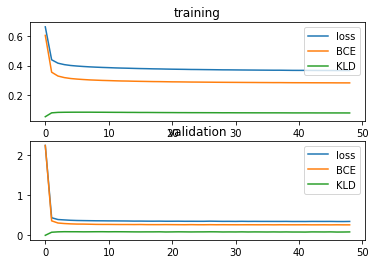

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(2, 1)
plt.subplot(2, 1, 1)
plt.plot(train_cache["loss"], label="loss")
plt.plot(train_cache["bce"], label="BCE")
plt.plot(train_cache["kld"], label="KLD")
plt.legend()
plt.title("training")
plt.subplot(2, 1, 2)
plt.plot(valid_cache["loss"], label="loss")
plt.plot(valid_cache["bce"], label="BCE")
plt.plot(valid_cache["kld"], label="KLD")
plt.legend()
plt.title("validation")

### D. Conditional generation

**Your task**: complete the code below to produce a grid of samples with 10 rows, where the $i$'th row has samples of class $i$.

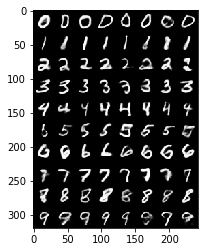

In [ ]:
from torchvision.utils import make_grid
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


N = 8
model = CVAE(zdim, nclasses).to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/DS1008/HW4/model_conditional.pt')["state_dict"])
model.eval()
grids = []
for y_ in range(10):
  z = torch.randn((N, zdim)).to(device) # 8 x zdim
  c = torch.empty(N).fill_(y_).type(torch.LongTensor).to(device)
  sample = model.decoder(z, c)

  grid = make_grid(sample).detach().cpu()
  grids.append(grid)

grid = torch.cat(grids, 1)
show(grid);